In [1]:
import torch
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

In [2]:
dist_hypo1 = sps.multivariate_normal([0,0],np.array([[2,0.2],[0.2,1]]))
X = dist_hypo1.rvs(size = (10,))

def simulator(theta, N = 10):
    dist_hypo1 = sps.multivariate_normal(theta,np.array([[2,0.2],[0.2,1]]))
    X = torch.FloatTensor(dist_hypo1.rvs(size = (N,)))
    return X

def true_log_likelihood_ratio(X, theta):
    dist_hypo2 = sps.multivariate_normal(theta,np.array([[2,0.2],[0.2,1]]))
    return dist_hypo2.logpdf(X).sum(axis = -1) - dist_hypo1.logpdf(X).sum(axis = -1)

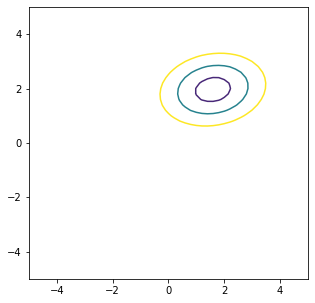

In [3]:
grid = np.mgrid[-5:5:51j,-5:5:51j]
thetas = np.swapaxes(grid,0,-1).reshape(-1,2)

X = simulator([2,2], N = 10)
nllr = np.array([-true_log_likelihood_ratio(X,t) for t in thetas])
grid_z = nllr.reshape(51,51).T
plt.contour(grid[0],grid[1], grid_z - grid_z.min(), levels = [0,1,4,9])
plt.gcf().set_size_inches(5,5)

In [104]:
def label_as(Xa,Xb, label_a, label_b):
    ya = label_a * torch.ones((Xa.shape[0],1))
    yb = label_b * torch.ones((Xb.shape[0],1))

    X = torch.concat([Xa,Xb])
    y = torch.concat([ya,yb])
    return X,y

def prep_data(theta, N = 123):
    Xa = simulator([0,0], N = N)
    Xb = simulator(theta, N = N)
    X,y = label_as(Xa,Xb,0,1)
    return X,y

def parametrize_input(X, theta):
    theta_cols = torch.ones(X.shape[0],1)*torch.tensor(theta)
    return torch.cat([X,theta_cols],dim = -1)

def train():
    model = torch.nn.Sequential(
        torch.nn.Linear(2 + 2,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,1),
        torch.nn.Sigmoid()
    )
    opt = torch.optim.Adam(model.parameters(), lr = 1e-3)

    for i in range(20000):
        theta = torch.FloatTensor(np.random.uniform(-3,3, size = (2,)))
        X,y = prep_data(theta)
        X = parametrize_input(X, theta)
        pred  = model(X)
        loss = torch.nn.functional.binary_cross_entropy(pred,y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 1000 == 0:
            print(float(loss),theta)
    return model

trained_model = train()

/var/folders/hn/y10jq2sn3cs3wnqv65l2rc040000gn/T/ipykernel_69490/577355997.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_cols = torch.ones(X.shape[0],1)*torch.tensor(theta)


0.7307738065719604 tensor([-2.2296,  2.6770])
0.42677322030067444 tensor([-0.4010, -2.1199])
0.31618884205818176 tensor([ 0.6400, -2.1653])
0.11540721356868744 tensor([ 2.6744, -2.6860])
0.33912453055381775 tensor([2.9047, 1.0208])
0.5983898043632507 tensor([-1.3844,  0.4458])
0.5828006863594055 tensor([ 0.2956, -0.9672])
0.2861905097961426 tensor([-0.2395,  2.2018])
0.2252758890390396 tensor([-1.2478, -2.7299])
0.31601226329803467 tensor([ 1.4051, -1.9549])
0.17281831800937653 tensor([-0.9609,  2.7089])
0.6040951013565063 tensor([-0.5856, -0.9640])
0.1972120702266693 tensor([1.6161, 2.6609])
0.3866923153400421 tensor([-1.8585,  1.1358])
0.3192443549633026 tensor([-0.4490, -2.2246])
0.37083008885383606 tensor([1.5957, 1.6919])
0.3060976564884186 tensor([-2.1864,  1.4814])
0.27830708026885986 tensor([0.7025, 2.5109])
0.16201743483543396 tensor([ 2.8468, -2.4704])
0.1846662163734436 tensor([-2.1694, -2.5754])


In [105]:
def eval_data(X, theta):
    theta = torch.FloatTensor(theta)
    X = parametrize_input(X,theta)
    with torch.no_grad():
        out = trained_model(X).detach()
    a = torch.log(out/(1-out))
    return -a.sum()

eval_data(X,[2,2])

/var/folders/hn/y10jq2sn3cs3wnqv65l2rc040000gn/T/ipykernel_69490/577355997.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_cols = torch.ones(X.shape[0],1)*torch.tensor(theta)


tensor(107.3941)

In [106]:
def analyze_data(X):
    grid = np.mgrid[-4:5:51j,-5:5:51j]
    thetas = np.swapaxes(grid,0,-1).reshape(-1,2)

    evals = np.array([eval_data(X,t) for t in thetas])
    grid_ml = evals.reshape(51,51).T

    nllr = np.array([-true_log_likelihood_ratio(X,t) for t in thetas])
    grid_truth = nllr.reshape(51,51).T
    
    ml_result = grid_ml - grid_ml.min()
    truth_result = grid_truth - grid_truth.min()
    
    return ml_result, truth_result




/var/folders/hn/y10jq2sn3cs3wnqv65l2rc040000gn/T/ipykernel_69490/577355997.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_cols = torch.ones(X.shape[0],1)*torch.tensor(theta)


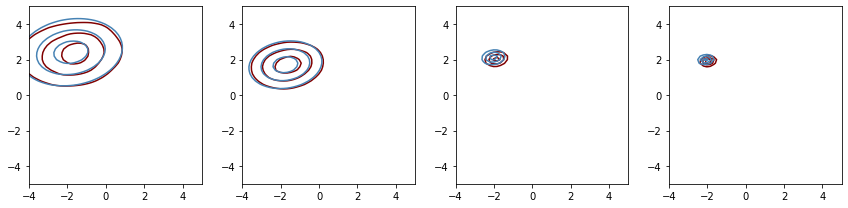

In [107]:

f, axarr = plt.subplots(1,4)

for ax, N in zip(axarr.ravel(), [5,10,100,200]):
    X = simulator([-2,2],N)
    ml,tr = analyze_data(X)
    ax.contour(grid[0],grid[1], ml, colors = 'maroon', levels = [0,1,4,9])
    ax.contour(grid[0],grid[1], tr, colors = 'steelblue', levels = [0,1,4,9])
f.set_size_inches(12,3)
f.set_tight_layout(True)